<a href="https://colab.research.google.com/github/varmatilak22/learning_tensorflow/blob/main/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

See the annotated version of this notebook on GitHub:


## Check our GPU
* Google colab offers free GPUS thanku google, not all of them are compatitble with mixed precision training.

Google Colab offers:
1. K80 (not comaptible)
2. P100 (not comaptible)
3. Tesla T4 (Compatible)

So knowing this in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+.(See here:https://developer.nvidia.com/cuda-gpus).


In [ ]:
# If the following line doesn;t output Tesla T4 you can try getting access to
# another GPU by going to RUNTIME -> Factory Reset -> 'Yes' and then
# re-runnning this cell
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-516d682e-52ae-f07c-7835-3755a8685d34)


## Get Helper functions

In past modules, we created bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these we can import a script and load it from there.

The Script we've got available can be found on GitHub:
https://raw.githubusercontent.com/varmatilak22/learning_tensorflow/main/extras/helper_func.py


In [ ]:
#Download helper functions scripts
!wget https://raw.githubusercontent.com/varmatilak22/learning_tensorflow/main/extras/helper_func.py

--2024-08-04 10:02:48--  https://raw.githubusercontent.com/varmatilak22/learning_tensorflow/main/extras/helper_func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13288 (13K) [text/plain]
Saving to: ‘helper_func.py.1’

helper_func.py.1    100%[===================>]  12.98K  --.-KB/s    in 0.001s  

2024-08-04 10:02:48 (21.3 MB/s) - ‘helper_func.py.1’ saved [13288/13288]



In [ ]:
# Import series of helper functions for the notebook
from helper_func import create_tensorboard_callback,plot_loss_curves,compare_historys

## 1. Become One with the data:Use Tensorflow Datasets

Iy you want get an overview of Tensorflow Datasets(TFDS), read the guide:https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html.

In [ ]:
#Get Tensorflow Datasets
import tensorflow_datasets as tfds


In [ ]:
#List all the available datasets
datasets_list=tfds.list_builders() #Get all available datasets in TFDS
print(f"food101" in datasets_list) #is our target dataset

True


In [ ]:
# Load in the data(5-6 mins in google colab)
(train_data,test_data),ds_info=tfds.load(name='food101',
                                         split=['train','validation'],
                                         shuffle_files=True,
                                         as_supervised=True,# Data gets returned in tuple format(data,label)
                                         with_info=True)

## Exploring the Food101 Datasets from tensorflow Datasets.

TO become with the data, we want to find:
* Class_names
* The Shape of our input data (image tensors)
* The datatype of input data
* What the labels look like (e.g. are they one_hot_encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names=ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of train data
train_one_sample=train_data.take(1) #Sample are informat image tensor and image label
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# WHat does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output information about training sample
for image,label in train_one_sample:
  print(f"""
  Image Shape: {image.shape},
  Image dtype:{image.dtype},
  Target Class from Food101(tensor form):{label},
  Class names(string form):{class_names[label.numpy()]}

  """)


  Image Shape: (512, 512, 3),
  Image dtype:<dtype: 'uint8'>,
  Target Class from Food101(tensor form):23,
  Class names(string form):churros

  


In [ ]:
# What does our image tensor looks TFDS Food 101 looks like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

In [ ]:
#What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=9>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an Image from tensorflow Datasets


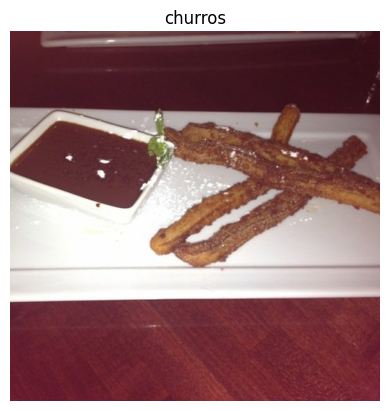

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with right
plt.axis(False);

## Create preprocessing functions for our data

Neural Networks perfroms best when data is in a certain way (e.g. batched,normalised,etc).

However , not all data (including data from TensorFlow  Datasets) comes like this.

So in order to get it ready for a neural network, you'll often  have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not Scaled (so pixel values between 0 and 255)

What we know models like:
* Data in `float32` dtype (or mixed precision `float16` and `float32`)
* For batches tensorflow likes all of the tensors within batch to be on same size.
* Scaled (values between 0 & 1) also called normalized tensors generally perfrom better

With these points in mind,we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications  we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all same size
2. Convert the dtypes of our image tensors from `uint8` to `float32`.


In [ ]:
#Make a function for preprocessing images
def preprocess_image(image,label,img_shape=224):
  """
  Conerts image datatype from `uint8` -> `float32` and reshaped image to image shape
  224,224,3 color channels.
  """
  image=tf.image.resize(image,[img_shape,img_shape]) #Reshape target image
  image=image/255.0 #nomarlise image
  return tf.cast(image,tf.float32), label # return (float32_image,label) tuple

In [ ]:
#Prepocess a simple sample image check the outputs
preprocessed_img=preprocess_image(image,label)[0]
print(f"Image before preprocessing:{image[:2]}...,\nShape:{image.shape},\nDataType:{image.dtype}")
print(f"Image after preprocessing:{preprocessed_img[:2]}...,\nShape:{preprocessed_img.shape},\nDataTyepe:{preprocessed_img.dtype}")

Image before preprocessing:[[[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]

 [[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]]...,
Shape:(512, 512, 3),
DataType:<dtype: 'uint8'>
Image after preprocessing:[[[0.3647059  0.13333334 0.15686275]
  [0.36862746 0.13725491 0.16078432]
  [0.37254903 0.14117648 0.16470589]
  ...
  [0.21568628 0.05882353 0.09411765]
  [0.20392157 0.05882353 0.09019608]
  [0.20392157 0.05882353 0.09019608]]

 [[0.36834735 0.1369748  0.1605042 ]
  [0.36498597 0.13361344 0.15714285]
  [0.36862746 0.13725491 0.16078432]
  ...
  [0.21568628 0.05882353 0.09411765]
  [0.21176471 0.05490196 0.09019608]
  [0.20392157 0.05882353 0.09019608]]]...,
Shape:(224, 224, 3),
DataTyepe:<dtype: 'float32'>


## Batch and preprare datasets

We're are going to make our data input pipeline run really fast.

For more resoucres on this ,I'd highly going through the following guide:https://www.tensorflow.org/guide/data_perfromance

In [ ]:
#Map preprocessing function to training(or parallelize)
train_data=train_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)

#Shuffle the train data and trun the it into batches and prefetch it (load it faster)
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map Preprocessing function to test data
test_data=test_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey Tensorflow this preprocessing funtion (`preprocess_img`) across our training data and test data,then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prepfetch) whilst the model is looking through (finding patterns) the current batch"

## Create Modelling callbacks

We're going to create  a couple of callbacks to help us while our model trains:
* Tensorboard Callback to log training results (so we can visualise them later if needed be)
* ModelCheckpointCallback to save our models progress after feature extraction.

In [ ]:
#Create tensorboard callback (import from helper_function.py)
from helper_func import create_tensorboard_callback

#Create a ModelCheckpoint Callback to save a models progress during training
checkpoint_path='model_checkpoints/cp.weights.h5'
model_checkpoints= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     save_freq='epoch',
                                                     monitor='val_accuracy',
                                                     verbose=0) # don;t print whether or not model is being saved

## Setup Mixed Precision Training

First and foremost, for a deeper understanding of mixed precision training;
Check out the tensorflow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

In [ ]:
# Turn on Mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') #Set global data policy to mixed precision

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build features extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomRotation,RandomHeight,RandomZoom,RandomWidth,RandomFlip

data_aug=tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2)
],name='Data_augmentation')

#Create a base Model
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create a functional model
input_layer=tf.keras.layers.Input(shape=input_shape,name='input_layer')
# Note: EfficientNetB0 models have rescaling built-in but if your model doesn't you can have
# x=Rescaling(1/255)(x)
x=data_aug(input_layer)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
output_layer=layers.Dense(len(class_names),activation='softmax',name='Output_layer',dtype=tf.float32)(x)
model=tf.keras.Model(inputs=input_layer,outputs=output_layer)

#Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
#Checking the dtype_policy attributes of layers in our model
for layer_number,layer in enumerate(model.layers):
  print(layer_number,layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

0 input_layer True float32 <DTypePolicy "float32">
1 Data_augmentation True float32 <DTypePolicy "float32">
2 efficientnetb0 False float32 <DTypePolicy "float32">
3 global_average_pooling_layer True float32 <DTypePolicy "float32">
4 Output_layer True float32 <DTypePolicy "float32">


Going through the above we see:
* `layer.name`:The human readable name of a particular layer
* `layer.trainable`:is the layer trainable or not (if `False`, the weights are frozen)
* `layer.dtype`: The datatype a layer stores its variables
* `layer.dtype_policy`: the data type policy a layer computes on its variables with  


In [ ]:
#Check the dtype policy attributes of layers in the base_model
for layer in model.layers[2].layers[:20]: # Check the layers of the base_model (layer at index 1 of 'model')
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer_3 False float32 <DTypePolicy "float32">
rescaling_4 False float32 <DTypePolicy "float32">
normalization_2 False float32 <DTypePolicy "float32">
rescaling_5 False float32 <DTypePolicy "float32">
stem_conv_pad False float32 <DTypePolicy "float32">
stem_conv False float32 <DTypePolicy "float32">
stem_bn False float32 <DTypePolicy "float32">
stem_activation False float32 <DTypePolicy "float32">
block1a_dwconv False float32 <DTypePolicy "float32">
block1a_bn False float32 <DTypePolicy "float32">
block1a_activation False float32 <DTypePolicy "float32">
block1a_se_squeeze False float32 <DTypePolicy "float32">
block1a_se_reshape False float32 <DTypePolicy "float32">
block1a_se_reduce False float32 <DTypePolicy "float32">
block1a_se_expand False float32 <DTypePolicy "float32">
block1a_se_excite False float32 <DTypePolicy "float32">
block1a_project_conv False float32 <DTypePolicy "float32">
block1a_project_bn False float32 <DTypePolicy "float32">
block2a_expand_conv False float32 <DT

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "float32">

In [ ]:
mixed_precision.set_global_policy('float32')

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model,the general order of doing things is:
1. Build a feature extraction model (train a couple outputs with base layers frozen).
2. Fine-tune some of the frozen layers

In [ ]:
# Fit feature extraction model with callbacks
history_101_food_classes_feature_extraction=model.fit(train_data,
                                                      epochs=3,
                                                      steps_per_epoch=(len(train_data)),
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15*len(test_data)),
                                                      callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                             experiment_name='feature_extraction'),model_checkpoints])

Saving TensorBoard log files to: transfer_learning/feature_extraction/20240804-112851
Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0094 - loss: 4.6689
Epoch 1: val_accuracy improved from -inf to 0.01086, saving model to model_checkpoints/cp.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 369s 149ms/step - accuracy: 0.0094 - loss: 4.6689 - val_accuracy: 0.0109 - val_loss: 4.6205
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
#Evaluate model on whole test dataset
results_feature_extraction=model.evaluate(test_data)
results_feature_extraction

## Off to you...

We've covered a lot of ground so far but since this is a milestone project its time for you to takeover.

More Specifically, you;re challenge is to complete the TEMPLATE version of 07 to obtain the computer vision model(building off the one we've built in this notebook) to beat DeepFood Paper.

In other words, you're going to create FoodVision Big!!!

You can find the TEMPLATE VERSION of notebook here:https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

And if you get struck, you can refer to the example version of (non-template):https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb